In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2603466/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                               | 0/50000 [00:00<?, ?it/s]

  9%|████████▍                                                                                        | 4341/50000 [00:00<00:01, 43400.42it/s]

 17%|████████████████▊                                                                                | 8682/50000 [00:00<00:00, 43015.25it/s]

 26%|████████████████████████▉                                                                       | 13012/50000 [00:00<00:00, 43141.05it/s]

 35%|█████████████████████████████████▎                                                              | 17327/50000 [00:00<00:00, 43076.64it/s]

 43%|█████████████████████████████████████████▋                                                      | 21695/50000 [00:00<00:00, 43291.80it/s]

 52%|█████████████████████████████████████████████████▉                                              | 26025/50000 [00:00<00:00, 42323.78it/s]

 61%|██████████████████████████████████████████████████████████▍                                     | 30436/50000 [00:00<00:00, 42895.33it/s]

 70%|██████████████████████████████████████████████████████████████████▉                             | 34881/50000 [00:00<00:00, 43382.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████▎                    | 39223/50000 [00:00<00:00, 43287.12it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▌            | 43554/50000 [00:01<00:00, 43095.49it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████    | 47933/50000 [00:01<00:00, 43302.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43178.38it/s]

Files already downloaded and verified


  0%|                                                                                                               | 0/10000 [00:00<?, ?it/s]

 42%|████████████████████████████████████████▉                                                        | 4224/10000 [00:00<00:00, 42235.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 8448/10000 [00:00<00:00, 41939.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42271.66it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 pnigdeyr


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pnigdeyr:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                 | 0/157 [00:00<?, ?it/s]

  1%|▋                                                                                                        | 1/157 [00:00<01:27,  1.77it/s]

  2%|██                                                                                                       | 3/157 [00:00<00:30,  5.07it/s]

  3%|███▎                                                                                                     | 5/157 [00:00<00:19,  7.76it/s]

  4%|████▋                                                                                                    | 7/157 [00:00<00:15,  9.86it/s]

  6%|██████                                                                                                   | 9/157 [00:01<00:12, 11.44it/s]

  7%|███████▎                                                                                                | 11/157 [00:01<00:11, 12.60it/s]

  8%|████████▌                                                                                               | 13/157 [00:01<00:10, 13.45it/s]

 10%|█████████▉                                                                                              | 15/157 [00:01<00:10, 14.06it/s]

 11%|███████████▎                                                                                            | 17/157 [00:01<00:09, 14.51it/s]

 12%|████████████▌                                                                                           | 19/157 [00:01<00:09, 14.82it/s]

 13%|█████████████▉                                                                                          | 21/157 [00:01<00:09, 15.04it/s]

 15%|███████████████▏                                                                                        | 23/157 [00:01<00:08, 15.19it/s]

 16%|████████████████▌                                                                                       | 25/157 [00:02<00:08, 15.30it/s]

 17%|█████████████████▉                                                                                      | 27/157 [00:02<00:08, 15.37it/s]

 18%|███████████████████▏                                                                                    | 29/157 [00:02<00:08, 15.42it/s]

 20%|████████████████████▌                                                                                   | 31/157 [00:02<00:08, 15.47it/s]

 21%|█████████████████████▊                                                                                  | 33/157 [00:02<00:08, 15.49it/s]

 22%|███████████████████████▏                                                                                | 35/157 [00:02<00:07, 15.50it/s]

 24%|████████████████████████▌                                                                               | 37/157 [00:02<00:07, 15.52it/s]

 25%|█████████████████████████▊                                                                              | 39/157 [00:03<00:07, 15.52it/s]

 26%|███████████████████████████▏                                                                            | 41/157 [00:03<00:07, 15.53it/s]

 27%|████████████████████████████▍                                                                           | 43/157 [00:03<00:07, 15.53it/s]

 29%|█████████████████████████████▊                                                                          | 45/157 [00:03<00:07, 15.54it/s]

 30%|███████████████████████████████▏                                                                        | 47/157 [00:03<00:07, 15.53it/s]

 31%|████████████████████████████████▍                                                                       | 49/157 [00:03<00:06, 15.53it/s]

 32%|█████████████████████████████████▊                                                                      | 51/157 [00:03<00:06, 15.54it/s]

 34%|███████████████████████████████████                                                                     | 53/157 [00:03<00:06, 15.54it/s]

 35%|████████████████████████████████████▍                                                                   | 55/157 [00:04<00:06, 15.55it/s]

 36%|█████████████████████████████████████▊                                                                  | 57/157 [00:04<00:06, 15.53it/s]

 38%|███████████████████████████████████████                                                                 | 59/157 [00:04<00:06, 15.52it/s]

 39%|████████████████████████████████████████▍                                                               | 61/157 [00:04<00:06, 15.53it/s]

 40%|█████████████████████████████████████████▋                                                              | 63/157 [00:04<00:06, 15.54it/s]

 41%|███████████████████████████████████████████                                                             | 65/157 [00:04<00:05, 15.55it/s]

 43%|████████████████████████████████████████████▍                                                           | 67/157 [00:04<00:05, 15.55it/s]

 44%|█████████████████████████████████████████████▋                                                          | 69/157 [00:04<00:05, 15.55it/s]

 45%|███████████████████████████████████████████████                                                         | 71/157 [00:05<00:05, 15.55it/s]

 46%|████████████████████████████████████████████████▎                                                       | 73/157 [00:05<00:05, 15.55it/s]

 48%|█████████████████████████████████████████████████▋                                                      | 75/157 [00:05<00:05, 15.55it/s]

 49%|███████████████████████████████████████████████████                                                     | 77/157 [00:05<00:05, 15.55it/s]

 50%|████████████████████████████████████████████████████▎                                                   | 79/157 [00:05<00:05, 15.55it/s]

 52%|█████████████████████████████████████████████████████▋                                                  | 81/157 [00:05<00:04, 15.55it/s]

 53%|██████████████████████████████████████████████████████▉                                                 | 83/157 [00:05<00:04, 15.54it/s]

 54%|████████████████████████████████████████████████████████▎                                               | 85/157 [00:05<00:04, 15.54it/s]

 55%|█████████████████████████████████████████████████████████▋                                              | 87/157 [00:06<00:04, 15.54it/s]

 57%|██████████████████████████████████████████████████████████▉                                             | 89/157 [00:06<00:04, 15.54it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 91/157 [00:06<00:04, 15.55it/s]

 59%|█████████████████████████████████████████████████████████████▌                                          | 93/157 [00:06<00:04, 15.55it/s]

 61%|██████████████████████████████████████████████████████████████▉                                         | 95/157 [00:06<00:03, 15.54it/s]

 62%|████████████████████████████████████████████████████████████████▎                                       | 97/157 [00:06<00:03, 15.54it/s]

 63%|█████████████████████████████████████████████████████████████████▌                                      | 99/157 [00:06<00:03, 15.55it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 101/157 [00:07<00:03, 15.55it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                   | 103/157 [00:07<00:03, 15.55it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 105/157 [00:07<00:03, 15.56it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 107/157 [00:07<00:03, 15.54it/s]

 69%|███████████████████████████████████████████████████████████████████████▌                               | 109/157 [00:07<00:03, 15.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                              | 111/157 [00:07<00:02, 15.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 113/157 [00:07<00:02, 15.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 115/157 [00:07<00:02, 15.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 117/157 [00:08<00:02, 15.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                         | 119/157 [00:08<00:02, 15.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 121/157 [00:08<00:02, 15.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▋                      | 123/157 [00:08<00:02, 15.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 125/157 [00:08<00:02, 15.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 127/157 [00:08<00:01, 15.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 129/157 [00:08<00:01, 15.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 131/157 [00:08<00:01, 15.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 133/157 [00:09<00:01, 15.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 135/157 [00:09<00:01, 15.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 137/157 [00:09<00:01, 15.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 139/157 [00:09<00:01, 15.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 141/157 [00:09<00:01, 15.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 143/157 [00:09<00:00, 15.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 145/157 [00:09<00:00, 15.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 147/157 [00:09<00:00, 15.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 149/157 [00:10<00:00, 15.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 151/157 [00:10<00:00, 15.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 153/157 [00:10<00:00, 15.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 155/157 [00:10<00:00, 15.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.77it/s]

train - OK


  0%|                                                                                                                  | 0/40 [00:00<?, ?it/s]

  2%|██▋                                                                                                       | 1/40 [00:00<00:05,  7.02it/s]

  8%|███████▉                                                                                                  | 3/40 [00:00<00:03, 11.78it/s]

 12%|█████████████▎                                                                                            | 5/40 [00:00<00:02, 13.44it/s]

 18%|██████████████████▌                                                                                       | 7/40 [00:00<00:02, 14.25it/s]

 22%|███████████████████████▊                                                                                  | 9/40 [00:00<00:02, 14.71it/s]

 28%|████████████████████████████▉                                                                            | 11/40 [00:00<00:01, 14.99it/s]

 32%|██████████████████████████████████▏                                                                      | 13/40 [00:00<00:01, 15.17it/s]

 38%|███████████████████████████████████████▍                                                                 | 15/40 [00:01<00:01, 15.28it/s]

 42%|████████████████████████████████████████████▋                                                            | 17/40 [00:01<00:01, 15.36it/s]

 48%|█████████████████████████████████████████████████▉                                                       | 19/40 [00:01<00:01, 15.41it/s]

 52%|███████████████████████████████████████████████████████▏                                                 | 21/40 [00:01<00:01, 15.45it/s]

 57%|████████████████████████████████████████████████████████████▎                                            | 23/40 [00:01<00:01, 15.47it/s]

 62%|█████████████████████████████████████████████████████████████████▋                                       | 25/40 [00:01<00:00, 15.50it/s]

 68%|██████████████████████████████████████████████████████████████████████▉                                  | 27/40 [00:01<00:00, 15.51it/s]

 72%|████████████████████████████████████████████████████████████████████████████▏                            | 29/40 [00:01<00:00, 15.51it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 31/40 [00:02<00:00, 15.52it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 33/40 [00:02<00:00, 15.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 35/40 [00:02<00:00, 15.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 37/40 [00:02<00:00, 15.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 39/40 [00:02<00:00, 15.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.91it/s]

val - OK


  0%|                                                                                                                  | 0/40 [00:00<?, ?it/s]

  2%|██▋                                                                                                       | 1/40 [00:00<00:05,  6.99it/s]

  8%|███████▉                                                                                                  | 3/40 [00:00<00:03, 11.76it/s]

 12%|█████████████▎                                                                                            | 5/40 [00:00<00:02, 13.45it/s]

 18%|██████████████████▌                                                                                       | 7/40 [00:00<00:02, 14.26it/s]

 22%|███████████████████████▊                                                                                  | 9/40 [00:00<00:02, 14.72it/s]

 28%|████████████████████████████▉                                                                            | 11/40 [00:00<00:01, 15.00it/s]

 32%|██████████████████████████████████▏                                                                      | 13/40 [00:00<00:01, 15.18it/s]

 38%|███████████████████████████████████████▍                                                                 | 15/40 [00:01<00:01, 15.30it/s]

 42%|████████████████████████████████████████████▋                                                            | 17/40 [00:01<00:01, 15.38it/s]

 48%|█████████████████████████████████████████████████▉                                                       | 19/40 [00:01<00:01, 15.43it/s]

 52%|███████████████████████████████████████████████████████▏                                                 | 21/40 [00:01<00:01, 15.47it/s]

 57%|████████████████████████████████████████████████████████████▎                                            | 23/40 [00:01<00:01, 15.50it/s]

 62%|█████████████████████████████████████████████████████████████████▋                                       | 25/40 [00:01<00:00, 15.51it/s]

 68%|██████████████████████████████████████████████████████████████████████▉                                  | 27/40 [00:01<00:00, 15.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████▏                            | 29/40 [00:01<00:00, 15.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 31/40 [00:02<00:00, 15.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 33/40 [00:02<00:00, 15.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 35/40 [00:02<00:00, 15.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 37/40 [00:02<00:00, 15.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 39/40 [00:02<00:00, 15.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.13it/s]

test InD - OK


  0%|                                                                                                                 | 0/235 [00:00<?, ?it/s]

  0%|▍                                                                                                        | 1/235 [00:00<00:34,  6.75it/s]

  1%|█▎                                                                                                       | 3/235 [00:00<00:20, 11.58it/s]

  2%|██▏                                                                                                      | 5/235 [00:00<00:17, 13.32it/s]

  3%|███▏                                                                                                     | 7/235 [00:00<00:16, 14.17it/s]

  4%|████                                                                                                     | 9/235 [00:00<00:15, 14.65it/s]

  5%|████▊                                                                                                   | 11/235 [00:00<00:14, 14.95it/s]

  6%|█████▊                                                                                                  | 13/235 [00:00<00:14, 15.14it/s]

  6%|██████▋                                                                                                 | 15/235 [00:01<00:14, 15.26it/s]

  7%|███████▌                                                                                                | 17/235 [00:01<00:14, 15.34it/s]

  8%|████████▍                                                                                               | 19/235 [00:01<00:14, 15.40it/s]

  9%|█████████▎                                                                                              | 21/235 [00:01<00:13, 15.44it/s]

 10%|██████████▏                                                                                             | 23/235 [00:01<00:13, 15.47it/s]

 11%|███████████                                                                                             | 25/235 [00:01<00:13, 15.48it/s]

 11%|███████████▉                                                                                            | 27/235 [00:01<00:13, 15.50it/s]

 12%|████████████▊                                                                                           | 29/235 [00:01<00:13, 15.51it/s]

 13%|█████████████▋                                                                                          | 31/235 [00:02<00:13, 15.52it/s]

 14%|██████████████▌                                                                                         | 33/235 [00:02<00:13, 15.52it/s]

 15%|███████████████▍                                                                                        | 35/235 [00:02<00:12, 15.53it/s]

 16%|████████████████▎                                                                                       | 37/235 [00:02<00:12, 15.53it/s]

 17%|█████████████████▎                                                                                      | 39/235 [00:02<00:12, 15.53it/s]

 17%|██████████████████▏                                                                                     | 41/235 [00:02<00:12, 15.53it/s]

 18%|███████████████████                                                                                     | 43/235 [00:02<00:12, 15.53it/s]

 19%|███████████████████▉                                                                                    | 45/235 [00:02<00:12, 15.53it/s]

 20%|████████████████████▊                                                                                   | 47/235 [00:03<00:12, 15.54it/s]

 21%|█████████████████████▋                                                                                  | 49/235 [00:03<00:11, 15.52it/s]

 22%|██████████████████████▌                                                                                 | 51/235 [00:03<00:11, 15.53it/s]

 23%|███████████████████████▍                                                                                | 53/235 [00:03<00:11, 15.54it/s]

 23%|████████████████████████▎                                                                               | 55/235 [00:03<00:11, 15.54it/s]

 24%|█████████████████████████▏                                                                              | 57/235 [00:03<00:11, 15.54it/s]

 25%|██████████████████████████                                                                              | 59/235 [00:03<00:11, 15.54it/s]

 26%|██████████████████████████▉                                                                             | 61/235 [00:04<00:11, 15.54it/s]

 27%|███████████████████████████▉                                                                            | 63/235 [00:04<00:11, 15.55it/s]

 28%|████████████████████████████▊                                                                           | 65/235 [00:04<00:10, 15.54it/s]

 29%|█████████████████████████████▋                                                                          | 67/235 [00:04<00:10, 15.54it/s]

 29%|██████████████████████████████▌                                                                         | 69/235 [00:04<00:10, 15.54it/s]

 30%|███████████████████████████████▍                                                                        | 71/235 [00:04<00:10, 15.55it/s]

 31%|████████████████████████████████▎                                                                       | 73/235 [00:04<00:10, 15.54it/s]

 32%|█████████████████████████████████▏                                                                      | 75/235 [00:04<00:10, 15.54it/s]

 33%|██████████████████████████████████                                                                      | 77/235 [00:05<00:10, 15.54it/s]

 34%|██████████████████████████████████▉                                                                     | 79/235 [00:05<00:10, 15.54it/s]

 34%|███████████████████████████████████▊                                                                    | 81/235 [00:05<00:09, 15.54it/s]

 35%|████████████████████████████████████▋                                                                   | 83/235 [00:05<00:09, 15.54it/s]

 36%|█████████████████████████████████████▌                                                                  | 85/235 [00:05<00:09, 15.54it/s]

 37%|██████████████████████████████████████▌                                                                 | 87/235 [00:05<00:09, 15.54it/s]

 38%|███████████████████████████████████████▍                                                                | 89/235 [00:05<00:09, 15.54it/s]

 39%|████████████████████████████████████████▎                                                               | 91/235 [00:05<00:09, 15.54it/s]

 40%|█████████████████████████████████████████▏                                                              | 93/235 [00:06<00:09, 15.55it/s]

 40%|██████████████████████████████████████████                                                              | 95/235 [00:06<00:09, 15.54it/s]

 41%|██████████████████████████████████████████▉                                                             | 97/235 [00:06<00:08, 15.54it/s]

 42%|███████████████████████████████████████████▊                                                            | 99/235 [00:06<00:08, 15.54it/s]

 43%|████████████████████████████████████████████▎                                                          | 101/235 [00:06<00:08, 15.54it/s]

 44%|█████████████████████████████████████████████▏                                                         | 103/235 [00:06<00:08, 15.55it/s]

 45%|██████████████████████████████████████████████                                                         | 105/235 [00:06<00:08, 15.54it/s]

 46%|██████████████████████████████████████████████▉                                                        | 107/235 [00:06<00:08, 15.53it/s]

 46%|███████████████████████████████████████████████▊                                                       | 109/235 [00:07<00:08, 15.53it/s]

 47%|████████████████████████████████████████████████▋                                                      | 111/235 [00:07<00:07, 15.54it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 113/235 [00:07<00:07, 15.54it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 115/235 [00:07<00:07, 15.54it/s]

 50%|███████████████████████████████████████████████████▎                                                   | 117/235 [00:07<00:07, 15.54it/s]

 51%|████████████████████████████████████████████████████▏                                                  | 119/235 [00:07<00:07, 15.55it/s]

 51%|█████████████████████████████████████████████████████                                                  | 121/235 [00:07<00:07, 15.54it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 123/235 [00:08<00:07, 15.54it/s]

 53%|██████████████████████████████████████████████████████▊                                                | 125/235 [00:08<00:07, 15.54it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 127/235 [00:08<00:06, 15.55it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 129/235 [00:08<00:06, 15.55it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 131/235 [00:08<00:06, 15.55it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 133/235 [00:08<00:06, 15.55it/s]

 57%|███████████████████████████████████████████████████████████▏                                           | 135/235 [00:08<00:06, 15.55it/s]

 58%|████████████████████████████████████████████████████████████                                           | 137/235 [00:08<00:06, 15.54it/s]

 59%|████████████████████████████████████████████████████████████▉                                          | 139/235 [00:09<00:06, 15.54it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 141/235 [00:09<00:06, 15.55it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 143/235 [00:09<00:05, 15.55it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 145/235 [00:09<00:05, 15.55it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 147/235 [00:09<00:05, 15.55it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 149/235 [00:09<00:05, 15.55it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 151/235 [00:09<00:05, 15.55it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 153/235 [00:09<00:05, 15.55it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 155/235 [00:10<00:05, 15.54it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 157/235 [00:10<00:05, 15.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 159/235 [00:10<00:04, 15.54it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                                | 161/235 [00:10<00:04, 15.55it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 163/235 [00:10<00:04, 15.55it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 165/235 [00:10<00:04, 15.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████▏                             | 167/235 [00:10<00:04, 15.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 169/235 [00:10<00:04, 15.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 171/235 [00:11<00:04, 15.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 173/235 [00:11<00:03, 15.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                          | 175/235 [00:11<00:03, 15.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 177/235 [00:11<00:03, 15.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 179/235 [00:11<00:03, 15.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 181/235 [00:11<00:03, 15.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 183/235 [00:11<00:03, 15.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                      | 185/235 [00:11<00:03, 15.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 187/235 [00:12<00:03, 15.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 189/235 [00:12<00:02, 15.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 191/235 [00:12<00:02, 15.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 193/235 [00:12<00:02, 15.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 195/235 [00:12<00:02, 15.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 197/235 [00:12<00:02, 15.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 199/235 [00:12<00:02, 15.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████               | 201/235 [00:13<00:02, 15.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 203/235 [00:13<00:02, 15.24it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 205/235 [00:13<00:01, 15.33it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 207/235 [00:13<00:01, 15.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 209/235 [00:13<00:01, 15.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 211/235 [00:13<00:01, 15.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 213/235 [00:13<00:01, 15.50it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 215/235 [00:13<00:01, 15.51it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 217/235 [00:14<00:01, 15.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 219/235 [00:14<00:01, 15.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 221/235 [00:14<00:00, 15.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 223/235 [00:14<00:00, 15.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 225/235 [00:14<00:00, 15.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 227/235 [00:14<00:00, 15.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 229/235 [00:14<00:00, 15.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 231/235 [00:14<00:00, 15.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 233/235 [00:15<00:00, 15.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.41it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:06, 15.52it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:06, 15.52it/s]

  6%|██████▎                                                                                                  | 6/100 [00:00<00:06, 15.52it/s]

  8%|████████▍                                                                                                | 8/100 [00:00<00:05, 15.53it/s]

 10%|██████████▍                                                                                             | 10/100 [00:00<00:05, 15.53it/s]

 12%|████████████▍                                                                                           | 12/100 [00:00<00:05, 15.53it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:00<00:05, 15.54it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:01<00:05, 15.54it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:01<00:05, 15.54it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:01<00:05, 15.54it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:01<00:05, 15.54it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:01<00:04, 15.54it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:01<00:04, 15.54it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:01<00:04, 15.54it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:01<00:04, 15.54it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:02<00:04, 15.54it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:02<00:04, 15.54it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:02<00:04, 15.54it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:02<00:03, 15.54it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:02<00:03, 15.54it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:02<00:03, 15.54it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:02<00:03, 15.54it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:02<00:03, 15.54it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:03<00:03, 15.55it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:03<00:03, 15.54it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:03<00:03, 15.54it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:03<00:02, 15.54it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:03<00:02, 15.54it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:03<00:02, 15.54it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:03<00:02, 15.54it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:03<00:02, 15.54it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:04<00:02, 15.53it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:04<00:02, 15.54it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:04<00:02, 15.54it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:04<00:01, 15.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:04<00:01, 15.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:04<00:01, 15.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:04<00:01, 15.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:05<00:01, 15.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:05<00:01, 15.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:05<00:01, 15.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:05<00:01, 15.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:05<00:00, 15.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:05<00:00, 15.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:05<00:00, 15.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:05<00:00, 15.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:06<00:00, 15.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:06<00:00, 15.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:06<00:00, 15.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.54it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(12800, 3, 32, 32) (12800, 3, 32, 32) (12800, 512) (12800, 5)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


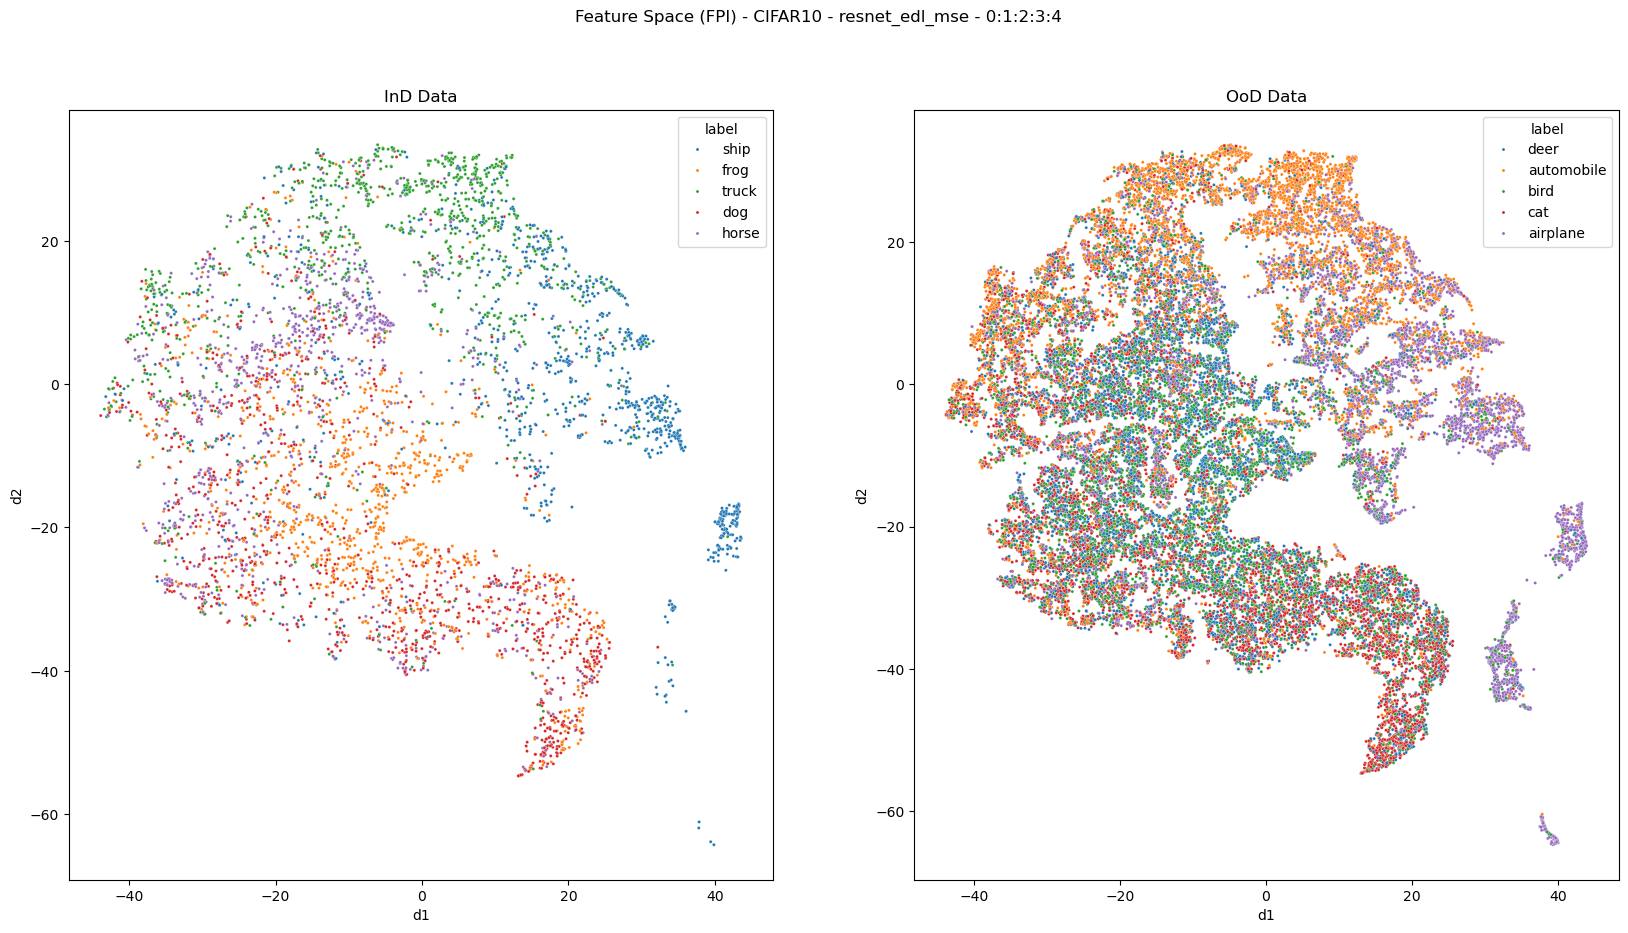

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

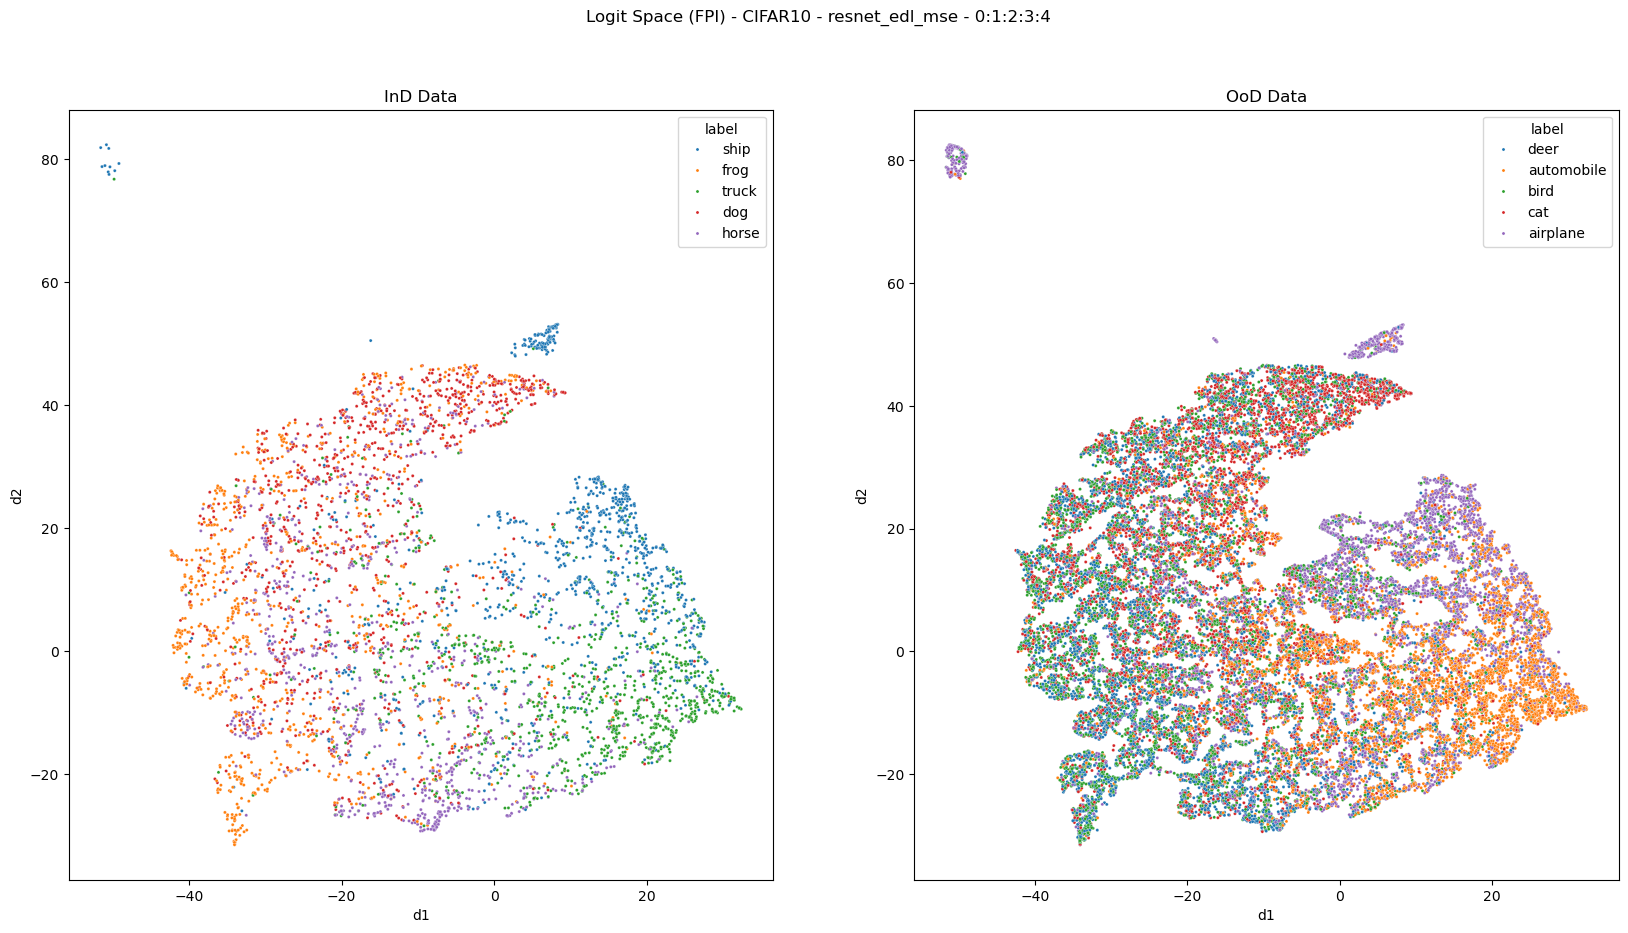

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:04,  1.54s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:02<00:02,  1.46s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:04<00:01,  1.47s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]

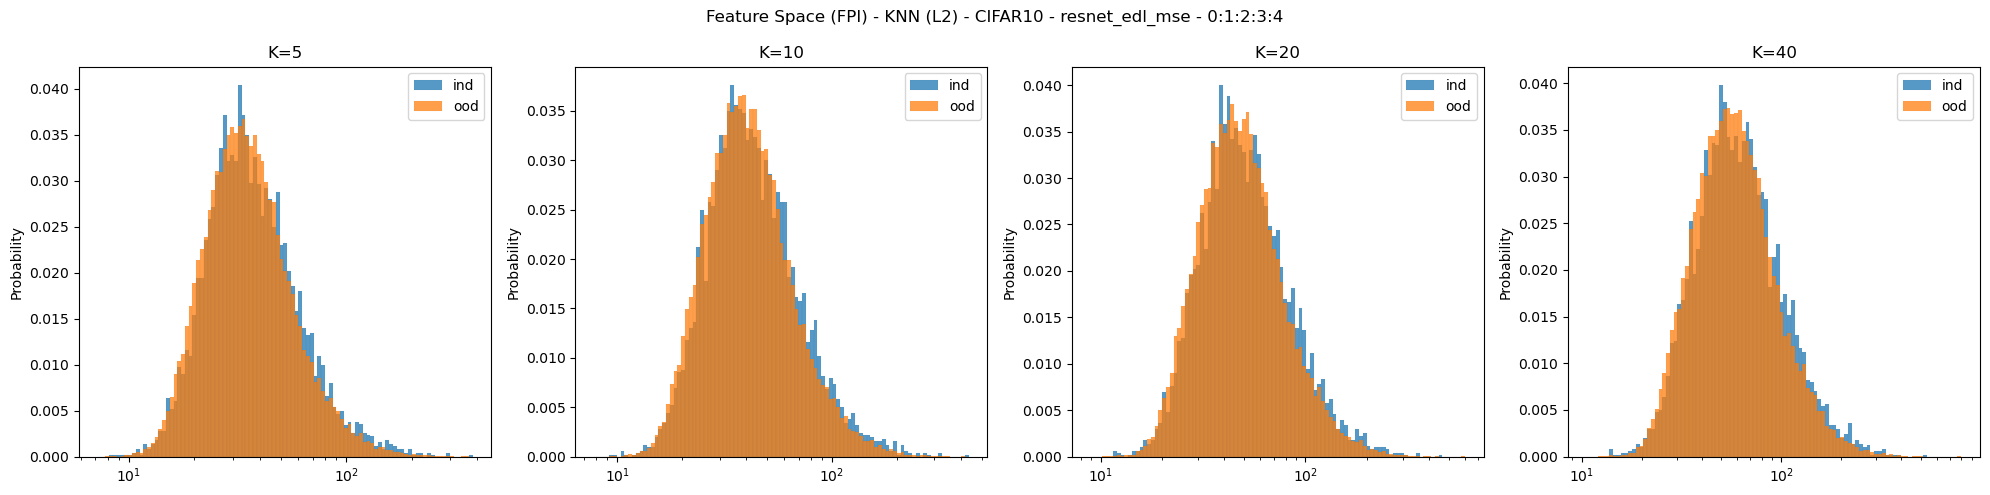

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:03,  1.33s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:02<00:02,  1.36s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:04<00:01,  1.47s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.53s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/it]

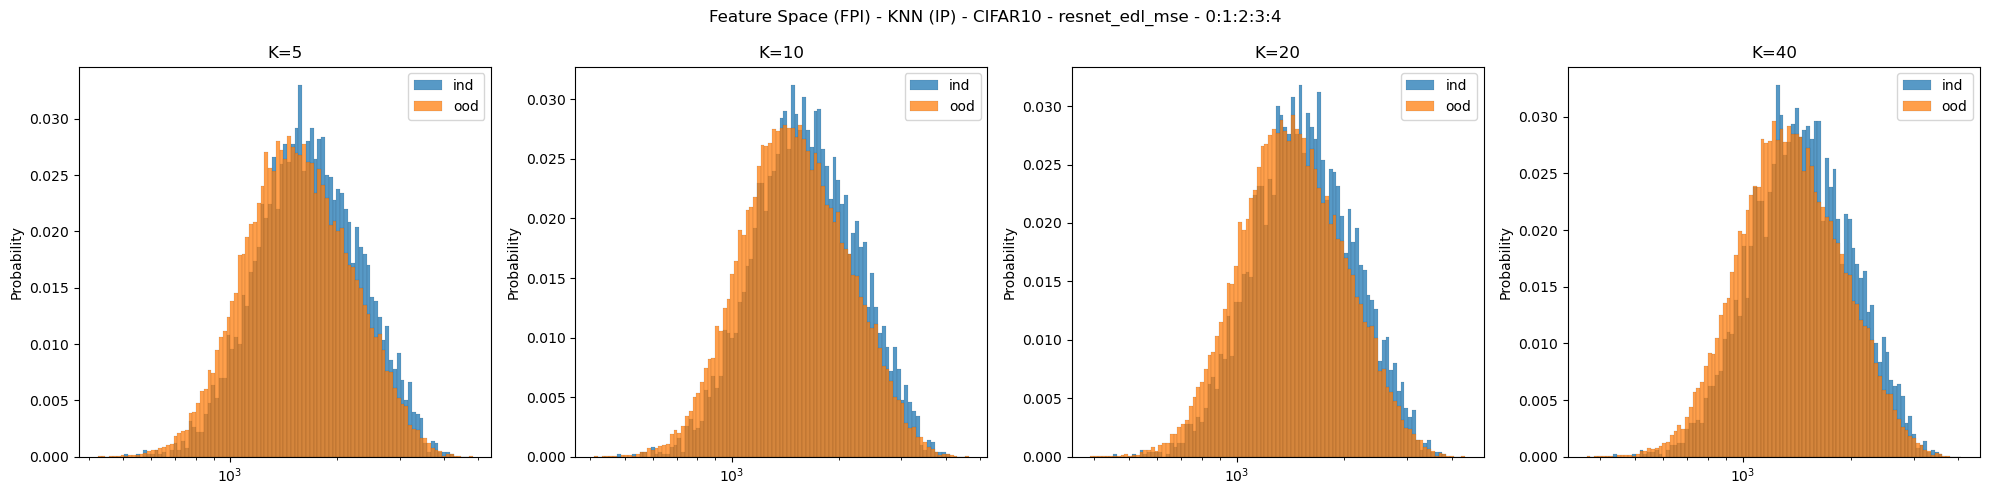

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:04,  1.37s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:02<00:02,  1.39s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:04<00:01,  1.43s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/it]

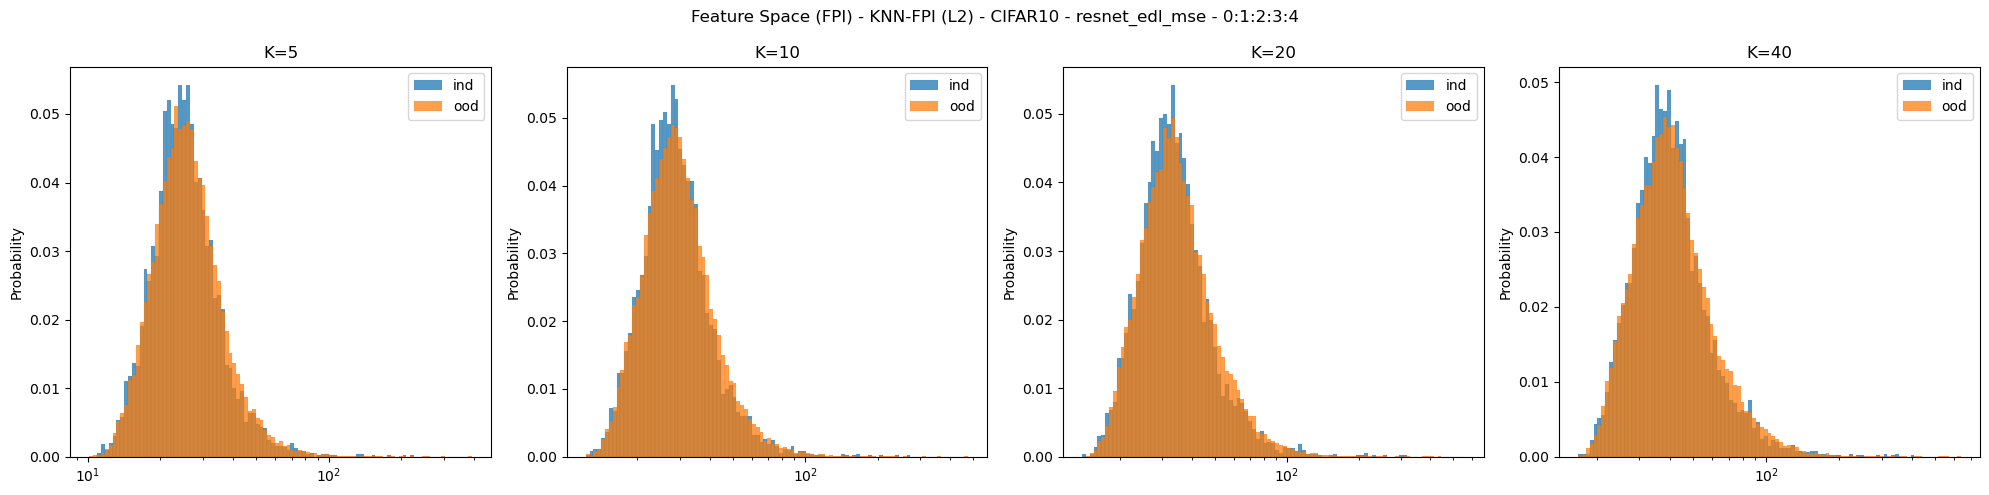

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:04,  1.34s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:02<00:03,  1.50s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:04<00:01,  1.48s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.50s/it]

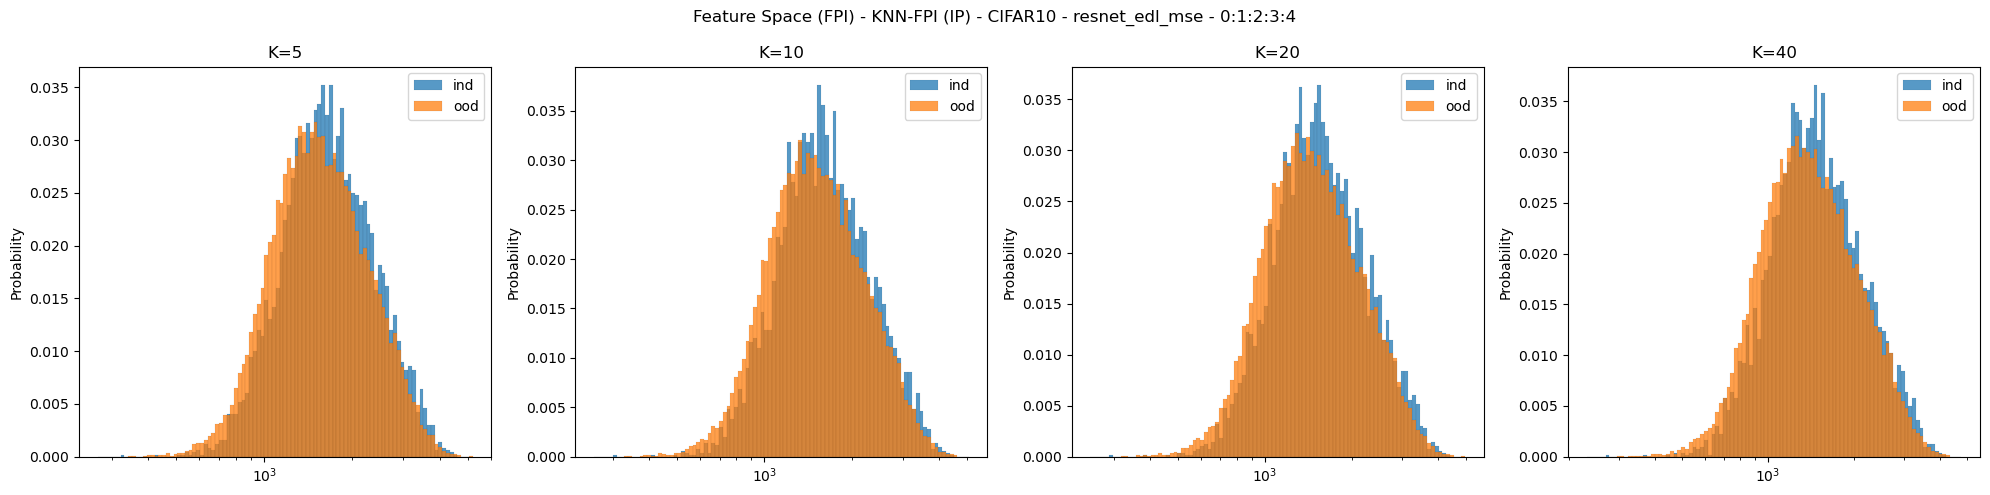

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:00,  3.17it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  3.01it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]

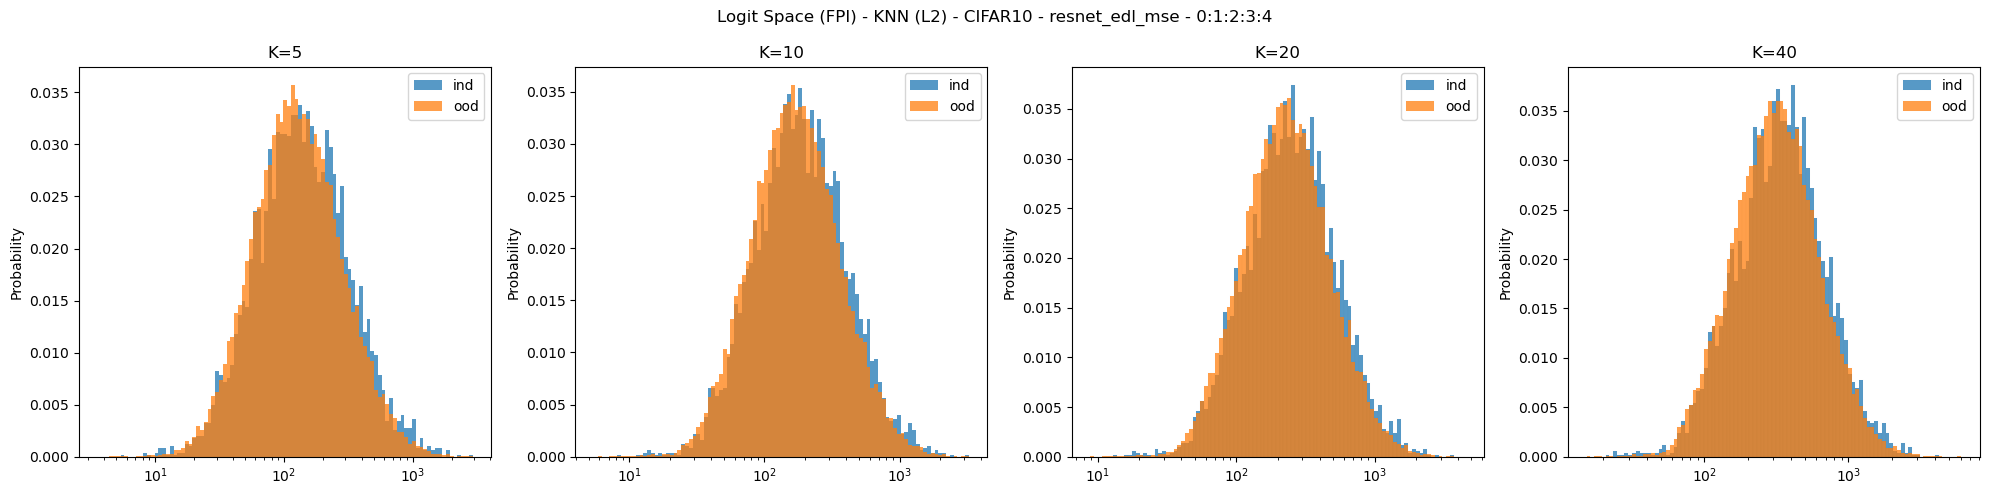

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:00,  3.56it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  2.27it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]

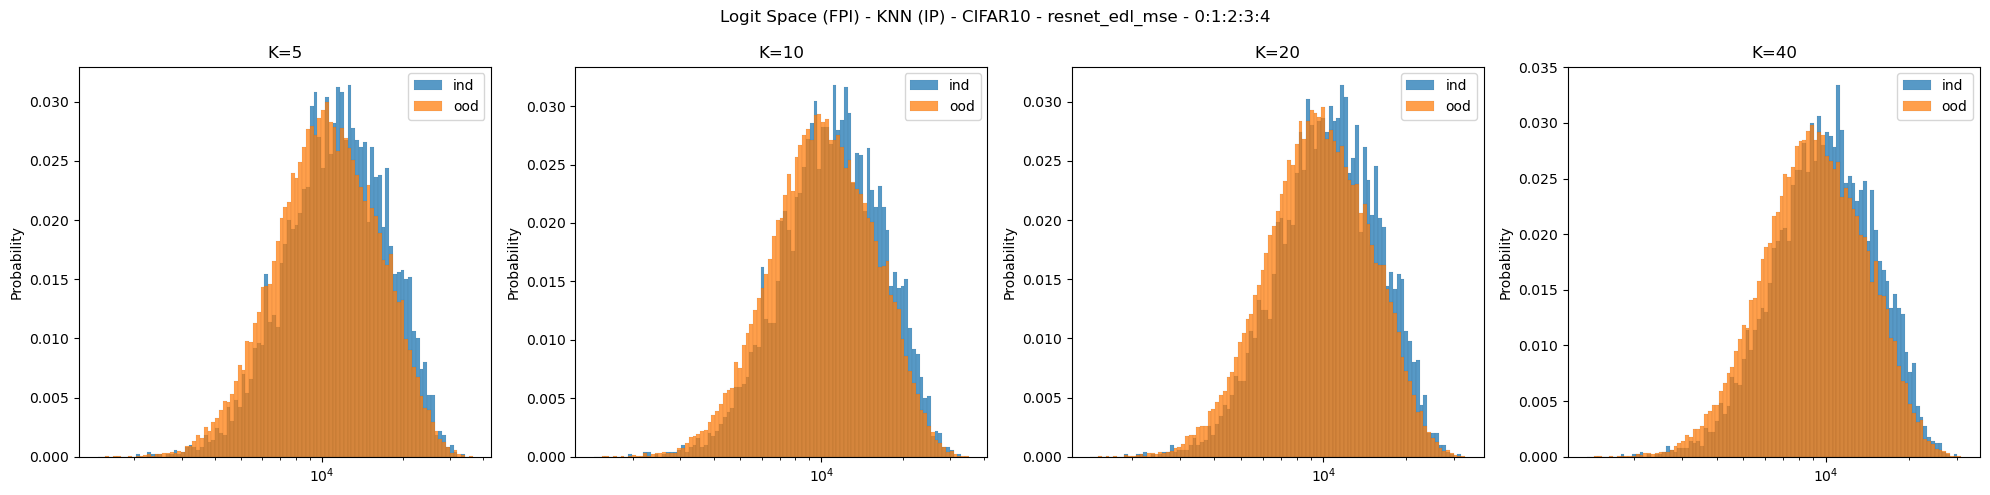

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:00,  3.22it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  3.03it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]

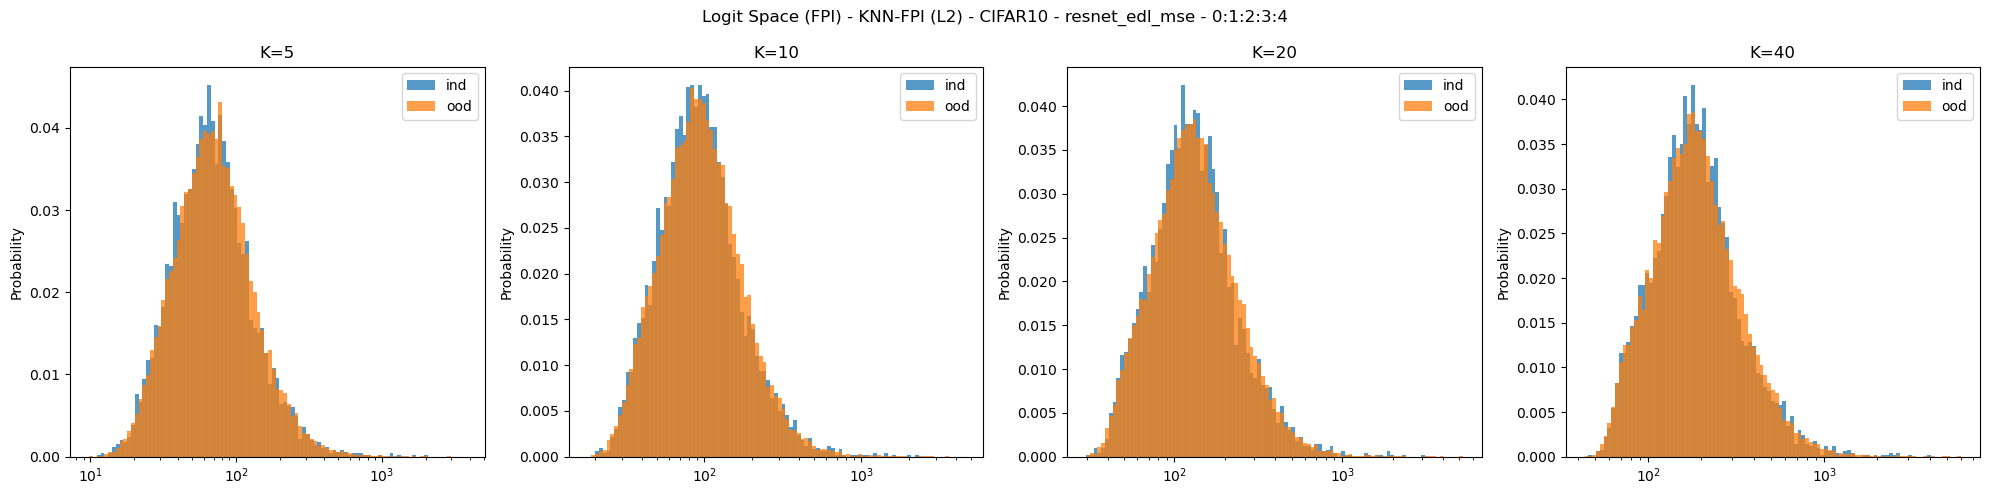

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:00<00:01,  1.93it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  2.50it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:01<00:00,  2.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]

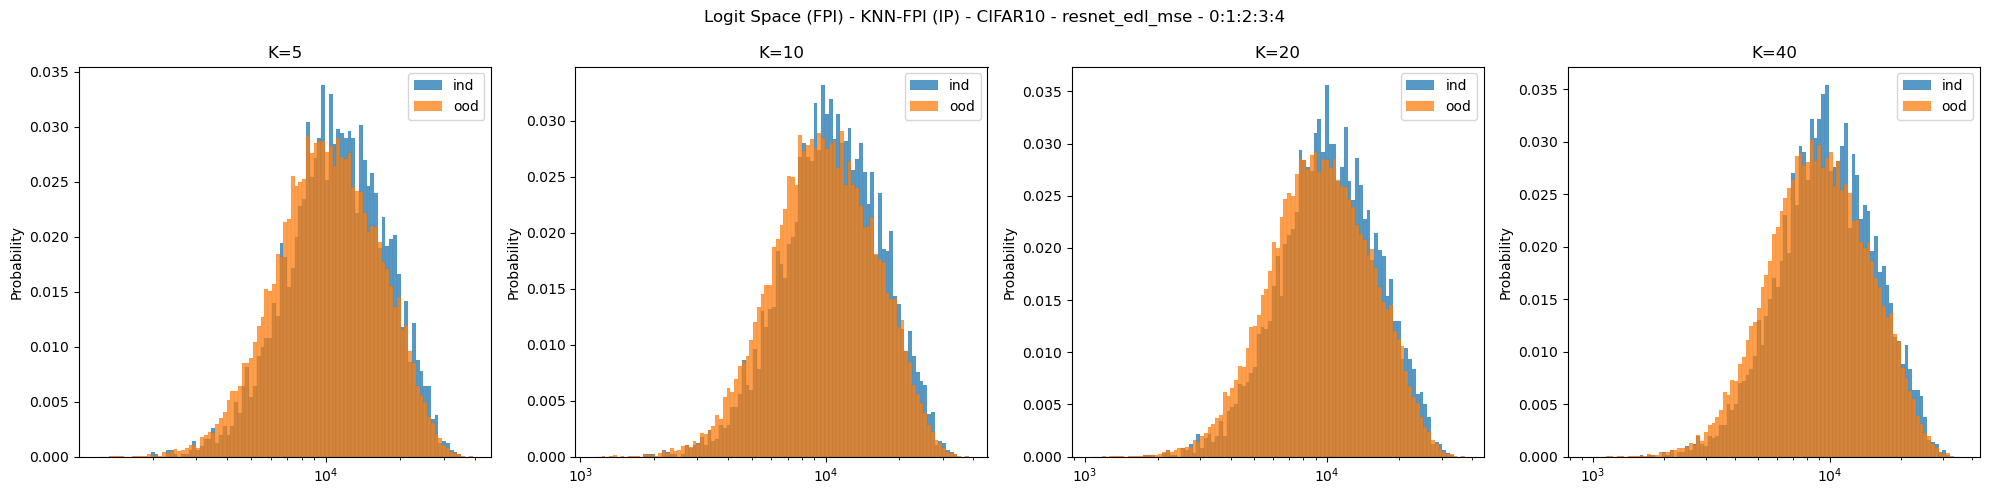

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

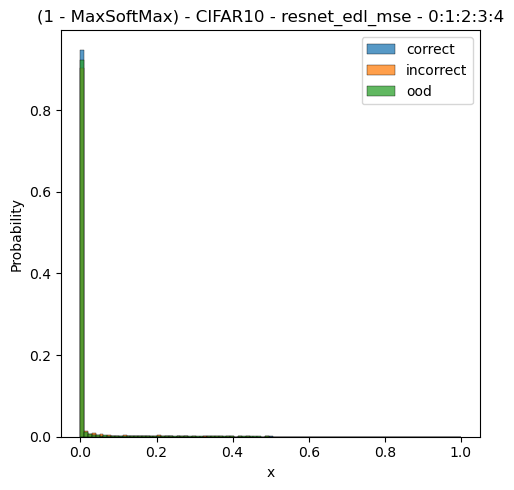

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

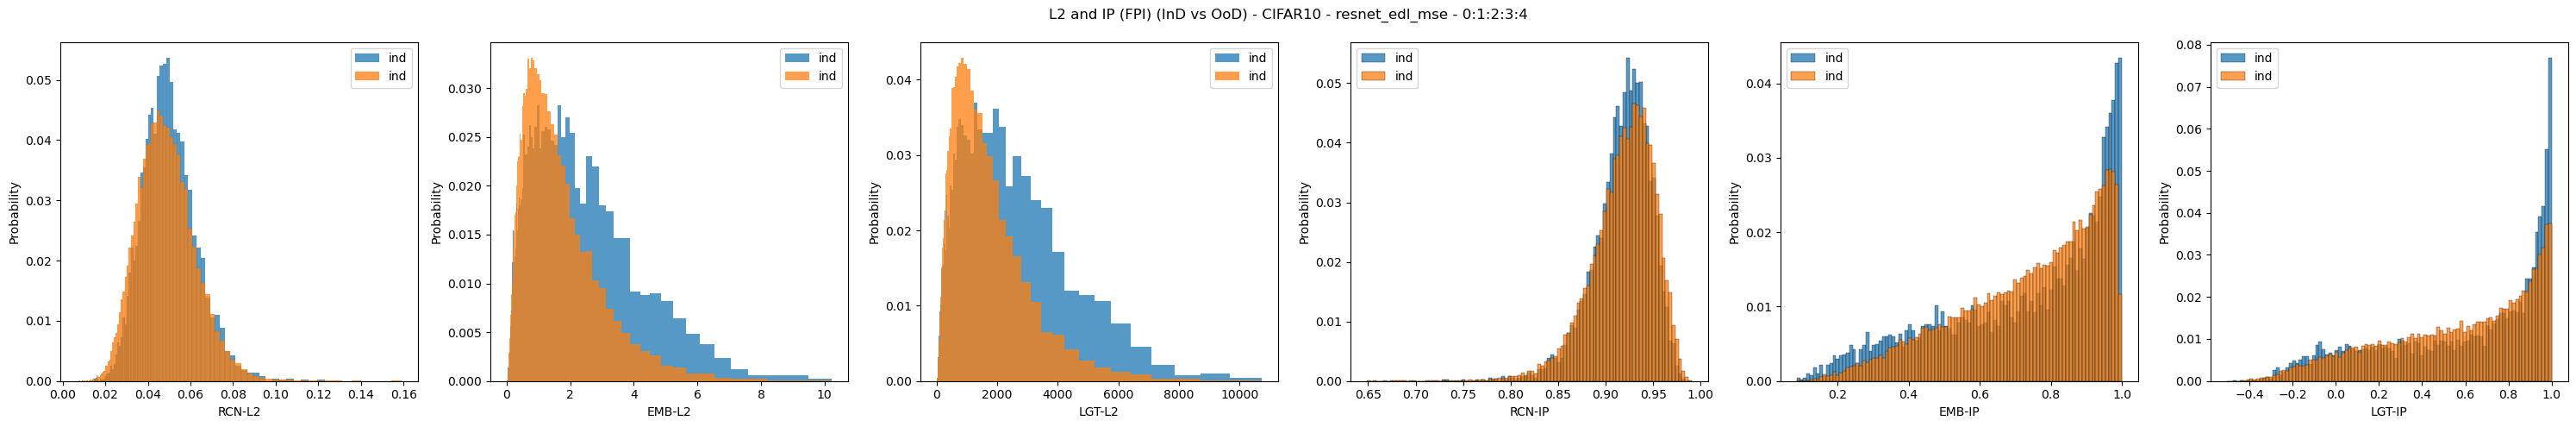

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()